This script should calculate the heat budget in for both cartesian and residual mean.

# Cartesian

The heat budget can written in the familiar form:
\begin{equation}
\frac{\partial T}{\partial t} + \nabla \cdot \textbf{u}T = \frac{\partial Q}{\partial z}
\end{equation}
 Where Q is the surface heat flux. Using a Reynolds decomposition to split the budget into eddy and mean transport terms gives:
 
\begin{equation}
\frac{\partial \overline{v}\overline{T}}{\partial y } + \frac{\partial \overline{w}\overline{T}}{\partial z } + \frac{\partial \overline{v'T'}}{\partial y } + \frac{\partial \overline{w'T'}}{\partial z } = \frac{\partial Q}{\partial z}.
\end{equation}

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os
import csv
import sys
from scipy.interpolate import interp1d
from scipy import interpolate
import numdifftools as nd
import numdifftools.nd_algopy as nda
from pylab import *
from matplotlib import gridspec
import netCDF4
import mpld3
sys.path.append('/noc/users/hb1g13/Python/python_functions/')
from useful import *
import layers_calc_numba
from Flat_channel import *
from HB_Plot import nf, fmt
import SG as SG
sys.path.append('/noc/users/hb1g13/Python/python_functions/MITgcmUtils/')
import utils
mpld3.enable_notebook()
%matplotlib inline

In [4]:
# Some parameters
Full = 'N'  # 9 Pannels isn't ideal for presentations N option give 4 plots

In [5]:
if Full == 'N':
    tau = ['3', '300', '3000', 'Closed']
elif Full == 'Extremes':
    tau = ['3','Closed']
else:
    tau = ['3', '10', '30', '100', '300',
           '1000', '3000', '10000', 'Closed']
Figletter = ['a) ','b) ','c) ','d) ','e)','f)','g)','h)','j)']
# Path root
x = '/noc/msm/scratch/students/hb1g13/Mobilis'
# Now Make file structure
check = 0
runs = []
for i in range(len(tau)):
    flist = x+'/'+str(tau[i])+'daynokpp/PSI.nc'
    if not os.path.exists(flist):
        print ' WARNING: '+flist+' does not exist! (skipping this tau...)'
        check += 0
    else:
        check += 1
        runs.append(i)
Runs=np.array(runs)

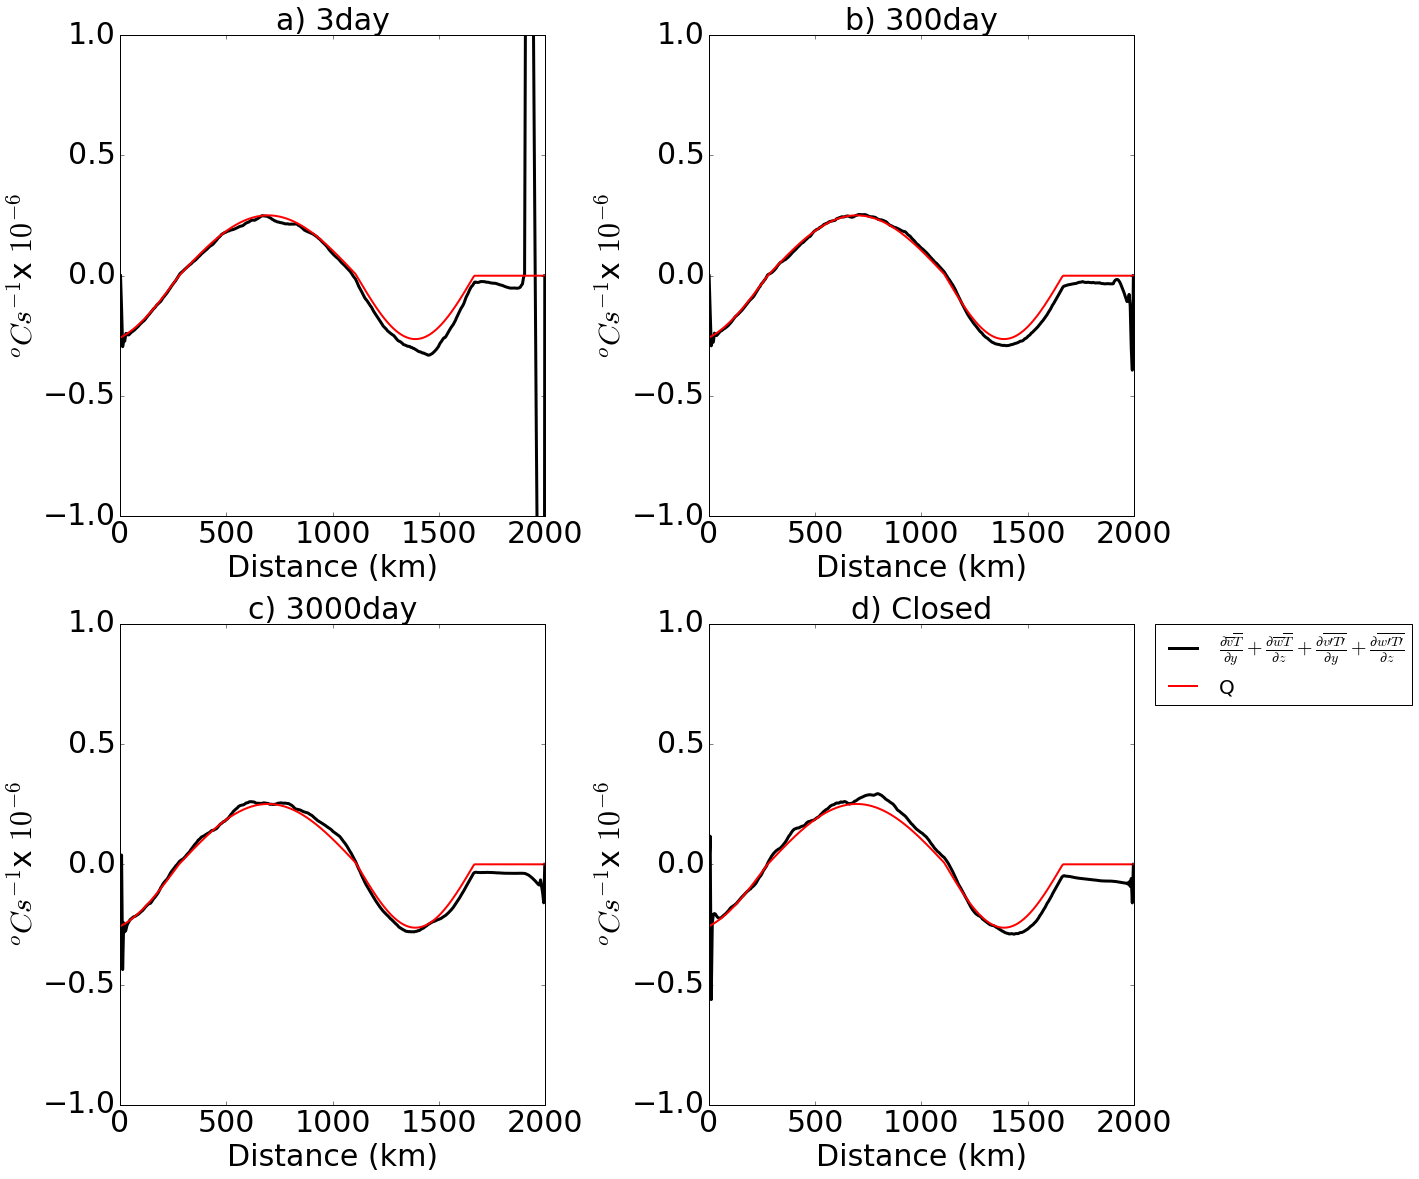

In [13]:

fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar                                                   
    # put everything on the C Grid                                                         
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((1, 0), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol
    Adv = (dVTe.sum(axis=0) + dWTe.sum(axis=0) + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol)
    Diff = -(5000*Adv).mean(axis=1)
    Q = c.mnc('SURF.nc','oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000,(Diff+Surcor)*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(Psipred/c.dzf[0])*10**6,'r',linewidth=2)
    plt.ylim(-1,1)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'$\frac{\partial\overline{v}\overline{T}}{\partial y}+\frac{\partial\overline{w}\overline{T}}{\partial z}+\frac{\partial \overline{v\prime T\prime }}{\partial y} + \frac{\partial \overline{w\prime T\prime }}{\partial z} $'
                  ,'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()


 The $\overline{v'T'}$ and $\overline{w'T'}$ terms can be decomposed into an along-isopycnal term and a horizontal component:

\begin{equation}
\left( \overline{v'T'},\overline{w'T'} \right) =  \underbrace{\left( \overline{v'T'}, \overline{v'T'}S_p \right)}_\text{along $\overline{T}$}  + \underbrace{\left( 0, \overline{w'T'}-\overline{v'T'}S_p \right)}_\text{remaining vertical}, 
\end{equation}

which can be substituted back in to the heat budget:
\begin{equation}
\frac{\partial \overline{v}\overline{T}}{\partial y } + \frac{\partial\overline{w} \overline{T}}{\partial z } + \frac{\partial \overline{v'T'}S_p}{\partial z } + \frac{\partial \overline{v'T'}}{\partial y } = \frac{\partial Q}{\partial z}+ \frac{\partial \left( \overline{w'T'}-\overline{v'T'}S_p \right)}{\partial z }.
\end{equation}



/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:34: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:34: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:35: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:36: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:37: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:38: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:36: RuntimeWarning: invalid value encountered in subtract
/noc/users/hb1g13/anaco

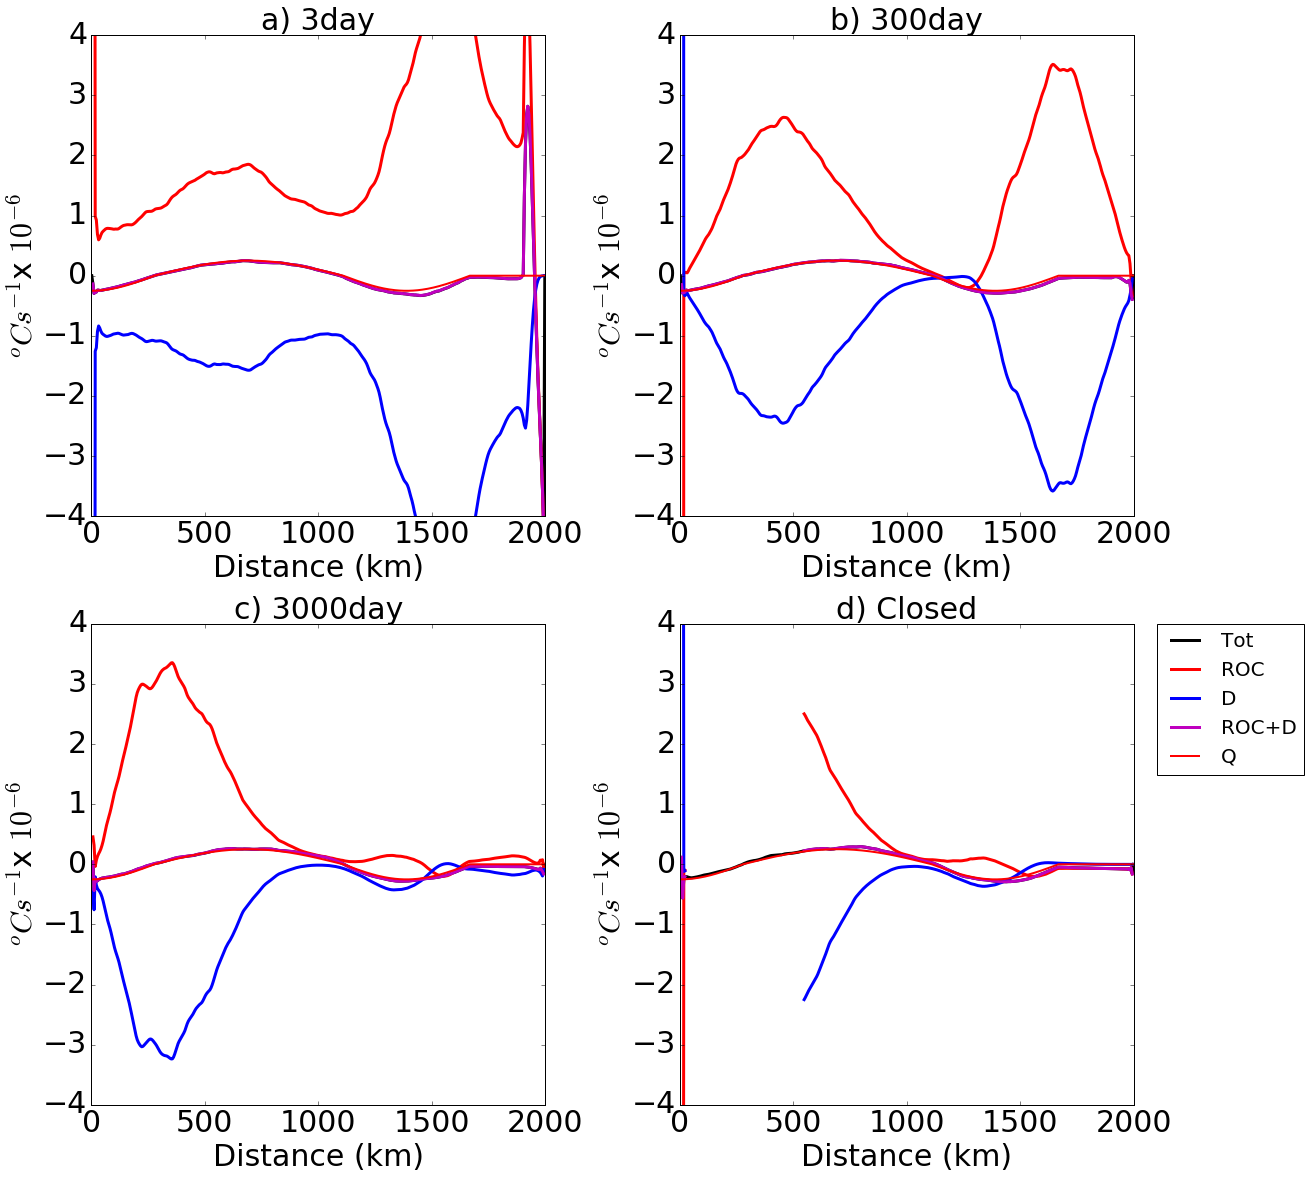

In [5]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((1, 0), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Ade = ((c.vgrid_to_cgrid(VpTp)*Sp)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTp)*Sp)[0:-1,:,:])*CellVol[0:-1,:,:]
    DE = ((c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[1::,:,:] 
          - (c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[0:-1,:,:])*CellVol[0:-1,:,:]
    D = -5000*((DE.sum(axis=0))/sum(CellVol)).mean(axis=1)
    ROC =-5000*((Ade.sum(axis=0) + dVTe.sum(axis=0) 
                 + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol)).mean(axis=1)
    Adv = ((dVTe.sum(axis=0) + dWTe.sum(axis=0)
           + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol))
    Adv = (dVTe.sum(axis=0) + dWTe.sum(axis=0) + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol)
    Diff = -(5000*Adv).mean(axis=1)
    Q = c.mnc('SURF.nc','oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000,(Diff+Surcor)*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC)*10**6,'r',linewidth=3)
    p = plt.plot(c.yc/1000,(D)*10**6,'b',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC+D+Surcor)*10**6,'m',linewidth=3)
    p = plt.plot(c.yc/1000,(Psipred/c.dzf[0])*10**6,'r',linewidth=2)
    plt.ylim(-4,4)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'Tot','ROC','D','ROC+D','Q',
                  'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:34: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:34: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:44: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:45: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:46: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:47: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:45: RuntimeWarning: invalid value encountered in subtract
/noc/users/hb1g13/anaco

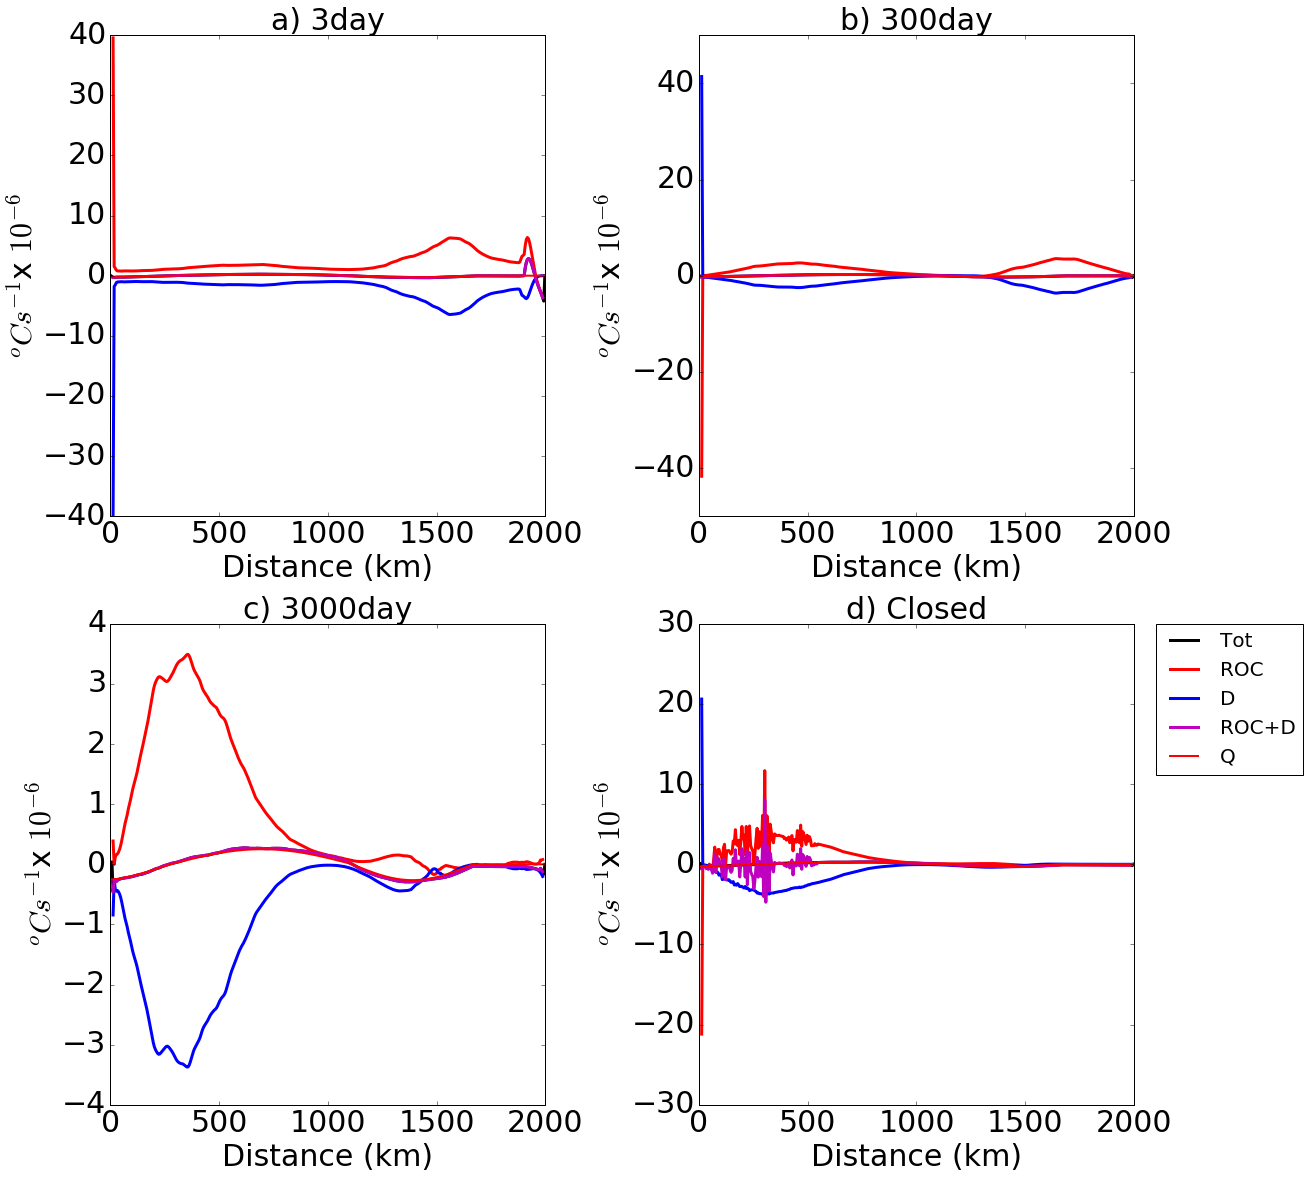

In [22]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((1, 0), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    g = layers_calc_numba.LayersComputer(c)
    # Layer probability mask 
    PI = c.mnc('PSI.nc',"LaPs1TH")#.mean(axis=2)
    th = c.mnc('PSI.nc',"LaHs1TH")#.mean(axis=2)
    PIz = g.transform_g_to_z(PI,th)
    CellVol = ma.masked_array(CellVol,c.vgrid_to_cgrid(PIz)<0.95)
    
    Ade = ((c.vgrid_to_cgrid(VpTp)*Sp)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTp)*Sp)[0:-1,:,:])*CellVol[0:-1,:,:]
    DE = ((c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[1::,:,:] 
          - (c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[0:-1,:,:])*CellVol[0:-1,:,:]
    D = -5000*((DE.sum(axis=0))/sum(CellVol)).mean(axis=1)
    ROC =-5000*((Ade.sum(axis=0) + dVTe.sum(axis=0) 
                 + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol)).mean(axis=1)
    Adv = ((dVTe.sum(axis=0) + dWTe.sum(axis=0)
           + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol))
    Adv = (dVTe.sum(axis=0) + dWTe.sum(axis=0) + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol)
    Diff = -(5000*Adv).mean(axis=1)
    Q = c.mnc('SURF.nc','oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000,(Diff+Surcor)*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC)*10**6,'r',linewidth=3)
    p = plt.plot(c.yc/1000,(D)*10**6,'b',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC+D+Surcor)*10**6,'m',linewidth=3)
    p = plt.plot(c.yc/1000,(Psipred/c.dzf[0])*10**6,'r',linewidth=2)
    #plt.ylim(-4,4)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'Tot','ROC','D','ROC+D','Q',
                  'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

# Interpolation test


/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:55: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:55: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:56: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:57: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:58: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:59: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:57: RuntimeWarning: invalid value encountered in subtract
/noc/users/hb1g13/anaco

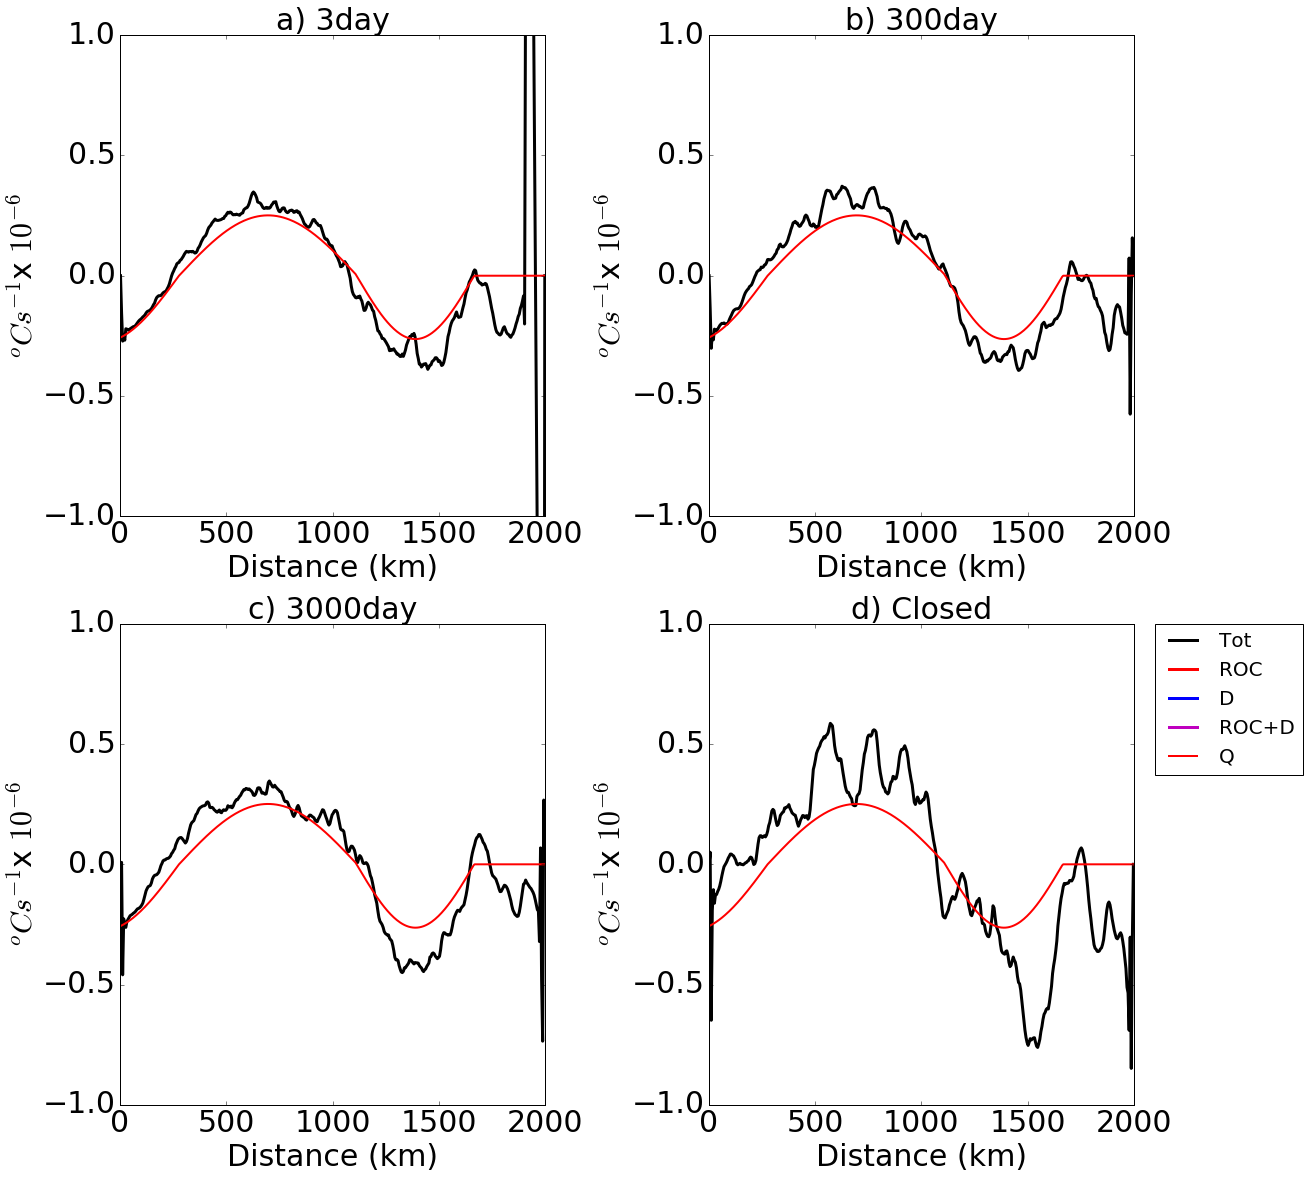

In [6]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((1, 0), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    ########################################################################
    Nzff = 900
    ZFF = np.linspace(c.zc[0],c.zc[-1],900)
    ZFFp = np.linspace(c.zf[0],c.zf[-1],901)
    VTbarff = zeros((900,401,200))
    WTbarff = zeros((901,400,200))
    VpTpff = zeros((900,401,200))
    WpTpff = zeros((901,400,200))
    Tvff = zeros((900,401,200))
    Twff = zeros((901,400,200))
    for ii in range(c.Nx-1):
        for jj in range(c.Ny):
            VTbarff[:,jj,ii] = interp(ZFF, c.zc[::-1], VTbar[::-1,jj,ii])
            VpTpff[:,jj,ii] = interp(ZFF, c.zc[::-1], VpTp[::-1,jj,ii])
            Tvff[:,jj,ii] = interp(ZFF, c.zc[::-1], Tv[::-1,jj,ii])
    for ii in range(c.Nx-1):
        for jj in range(c.Ny-1):
            Twff[:,jj,ii] = interp(ZFFp, c.zf[::-1], Tw[::-1,jj,ii])
            WpTpff[:,jj,ii] = interp(ZFFp, c.zf[::-1], WpTp[::-1,jj,ii])
            WTbarff[:,jj,ii] = interp(ZFFp, c.zf[::-1], WTbar[::-1,jj,ii])
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    CellVolff = c.rac*tile((ZFFp[0:-1]-ZFFp[1::]),(c.Nx,c.Ny,1)).T
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbarff[:,0:-1,:] - VTbarff[:,1::,:])*CellVolff
    dWTbar = (WTbarff[1::,:,:] - WTbarff[0:-1,:,:])*CellVolff
    dVTe = (VpTpff[:,0:-1,:] - VpTpff[:,1::,:])*CellVolff
    dWTe = (WpTpff[1::,:,:] - WpTpff[0:-1,:,:])*CellVolff
    Ty = (Tvff[:,0:-1,:] - Tvff[:,1::,:])*CellVolff
    Tz = (Twff[1::,:,:] - Twff[0:-1,:,:])*CellVolff
    Sp = zeros((Nzff,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Ade = ((c.vgrid_to_cgrid(VpTpff)*Sp)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTpff)*Sp)[0:-1,:,:])*CellVolff[0:-1,:,:] 
    DE = ((c.wgrid_to_cgridnz(WpTpff,601)-(c.vgrid_to_cgrid(VpTpff)*Sp))[1::,:,:] 
          - (c.wgrid_to_cgridnz(WpTpff,601)-(c.vgrid_to_cgrid(VpTpff)*Sp))[0:-1,:,:])*CellVolff[0:-1,:,:] 
    D = -5000*((DE.sum(axis=0))/sum(CellVol)).mean(axis=1)
    ROC =-5000*((Ade.sum(axis=0) + dVTe.sum(axis=0) 
                + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVolff)).mean(axis=1)
    Adv = ((dVTe.sum(axis=0) + dWTe.sum(axis=0)
           + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol))
    Adv = (dVTe.sum(axis=0) + dWTe.sum(axis=0) + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol)
    Diff = -(5000*Adv).mean(axis=1)
    Q = c.mnc('SURF.nc','oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000,(Diff+Surcor)*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC)*10**6,'r',linewidth=3)
    p = plt.plot(c.yc/1000,(D)*10**6,'b',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC+D+Surcor)*10**6,'m',linewidth=3)
    p = plt.plot(c.yc/1000,(Psipred/c.dzf[0])*10**6,'r',linewidth=2)
    plt.ylim(-1,1)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'Tot','ROC','D','ROC+D','Q',
                  'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:57: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:57: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:59: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:60: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:61: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:62: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:60: RuntimeWarning: invalid value encountered in subtract
/noc/users/hb1g13/anaco

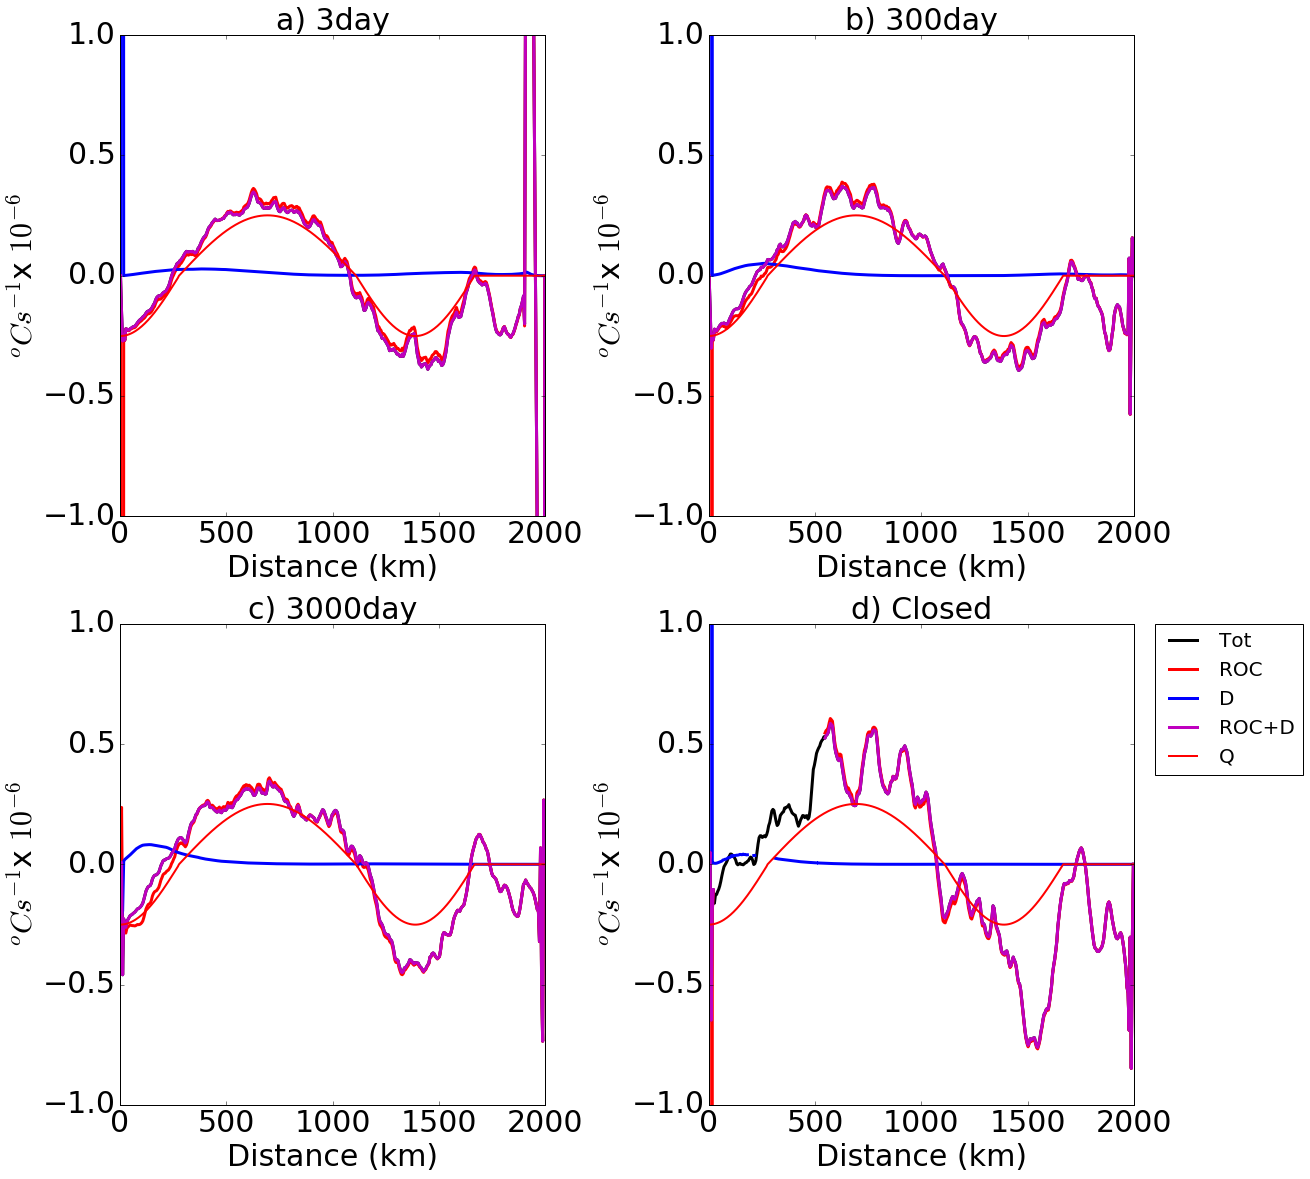

In [9]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((1, 0), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    ########################################################################
    # LAYERS STYLE ITERPOLATION
    FineGridFact = 20
    Nzff = 900
    ZFF = np.linspace(c.zc[0],c.zc[-1],900)
    ZFFp = np.linspace(c.zf[0],c.zf[-1],901)
    VTbarff = zeros((900,401,200))
    WTbarff = zeros((901,400,200))
    VpTpff = zeros((900,401,200))
    WpTpff = zeros((901,400,200))
    Tvff = zeros((900,401,200))
    Twff = zeros((901,400,200))
    for ii in range(c.Nx-1):
        for jj in range(c.Ny):
            VTbarff[:,jj,ii] = interp(ZFF, c.zc[::-1], VTbar[::-1,jj,ii])
            VpTpff[:,jj,ii] = interp(ZFF, c.zc[::-1], VpTp[::-1,jj,ii])
            Tvff[:,jj,ii] = interp(ZFF, c.zc[::-1], Tv[::-1,jj,ii])
    for ii in range(c.Nx-1):
        for jj in range(c.Ny-1):
            Twff[:,jj,ii] = interp(ZFFp, c.zf[::-1], Tw[::-1,jj,ii])
            WpTpff[:,jj,ii] = interp(ZFFp, c.zf[::-1], WpTp[::-1,jj,ii])
            WTbarff[:,jj,ii] = interp(ZFFp, c.zf[::-1], WTbar[::-1,jj,ii])
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    CellVolff = c.rac*tile((ZFFp[0:-1]-ZFFp[1::]),(c.Nx,c.Ny,1)).T
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbarff[:,0:-1,:] - VTbarff[:,1::,:])*CellVolff
    dWTbar = (WTbarff[1::,:,:] - WTbarff[0:-1,:,:])*CellVolff
    dVTe = (VpTpff[:,0:-1,:] - VpTpff[:,1::,:])*CellVolff
    dWTe = (WpTpff[1::,:,:] - WpTpff[0:-1,:,:])*CellVolff
    Ty = (Tvff[:,0:-1,:] - Tvff[:,1::,:])*CellVolff
    Tz = (Twff[1::,:,:] - Twff[0:-1,:,:])*CellVolff
    Sp = zeros((Nzff,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Sp[Sp==inf]=np.nan
    Ade = ((c.vgrid_to_cgrid(VpTpff)*Sp)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTpff)*Sp)[0:-1,:,:])*CellVolff[0:-1,:,:] 
    DE = ((c.wgrid_to_cgridnz(WpTpff,901)-(c.vgrid_to_cgrid(VpTpff)*Sp))[1::,:,:] 
          - (c.wgrid_to_cgridnz(WpTpff,901)-(c.vgrid_to_cgrid(VpTpff)*Sp))[0:-1,:,:])*CellVolff[0:-1,:,:] 
    D = -5000*np.nanmean(((np.nansum(DE,axis=0))/sum(CellVol)),axis=1)
    ROC =-5000*((np.nansum(Ade,axis=0) + np.nansum(dVTe,axis=0) 
                 + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol)).mean(axis=1)

    Adv = (dVTe.sum(axis=0) + dWTe.sum(axis=0) + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol)
    Diff = -(5000*Adv).mean(axis=1)
    Q = c.mnc('SURF.nc','oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000,(Diff+Surcor)*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC)*10**6,'r',linewidth=3)
    p = plt.plot(c.yc/1000,(D)*10**6,'b',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC+D+Surcor)*10**6,'m',linewidth=3)
    p = plt.plot(c.yc/1000,(Psipred/c.dzf[0])*10**6,'r',linewidth=2)
    plt.ylim(-1,1)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'Tot','ROC','D','ROC+D','Q',
                  'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

## Cartesian mixed layer depth

In [ ]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
        # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((1, 0), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol#[0:-1,:,:]
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol#[0:-1,:,:]
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol#[0:-1,:,:]
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Ade = ((c.vgrid_to_cgrid(VpTp)*Sp)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTp)*Sp)[0:-1,:,:])*CellVol[0:-1,:,:] 
    DE = ((c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[1::,:,:] 
          - (c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[0:-1,:,:])*CellVol[0:-1,:,:] 
    D = -5000*((DE.sum(axis=0))/sum(CellVol)).mean(axis=1)
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((1, 0), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    MLD = (c.mnc('MLD.nc','MXLDEPTH')).mean(axis=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    ########################################################################
    # LAYERS STYLE ITERPOLATION
    FineGridFact = 20
    Nzff = 900
    ZFF = np.linspace(c.zc[0],c.zc[-1],900)
    ZFFp = np.linspace(c.zf[0],c.zf[-1],901)
    VTbarff = zeros((900,401,200))
    WTbarff = zeros((901,400,200))
    VpTpff = zeros((900,401,200))
    WpTpff = zeros((901,400,200))
    Tvff = zeros((900,401,200))
    Twff = zeros((901,400,200))
    for ii in range(c.Nx-1):
        for jj in range(c.Ny):
            VTbarff[:,jj,ii] = interp(ZFF, c.zc[::-1], VTbar[::-1,jj,ii])
            VpTpff[:,jj,ii] = interp(ZFF, c.zc[::-1], VpTp[::-1,jj,ii])
            Tvff[:,jj,ii] = interp(ZFF, c.zc[::-1], Tv[::-1,jj,ii])
    for ii in range(c.Nx-1):
        for jj in range(c.Ny-1):
            Twff[:,jj,ii] = interp(ZFFp, c.zf[::-1], Tw[::-1,jj,ii])
            WpTpff[:,jj,ii] = interp(ZFFp, c.zf[::-1], WpTp[::-1,jj,ii])
            WTbarff[:,jj,ii] = interp(ZFFp, c.zf[::-1], WTbar[::-1,jj,ii])
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    CellVolff = c.rac*tile((ZFFp[0:-1]-ZFFp[1::]),(c.Nx,c.Ny,1)).T
    mxlvol = c.rac*MLD
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbarff[:,0:-1,:] - VTbarff[:,1::,:])*CellVolff
    dWTbar = (WTbarff[1::,:,:] - WTbarff[0:-1,:,:])*CellVolff#[0:-1,:,:]
    dVTe = (VpTpff[:,0:-1,:] - VpTpff[:,1::,:])*CellVolff
    dWTe = (WpTpff[1::,:,:] - WpTpff[0:-1,:,:])*CellVolff#[0:-1,:,:]
    Ty = (Tvff[:,0:-1,:] - Tvff[:,1::,:])*CellVolff
    Tz = (Twff[1::,:,:] - Twff[0:-1,:,:])*CellVolff#[0:-1,:,:]
    Sp = zeros((Nzff,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Sp[Sp==inf]=np.nan
    Sp[Sp==nan] = 0
    Zmatrix = tile(ZFF,(c.Nx,c.Ny,1)).T
    Zpmatrix = tile(ZFFp,(c.Nx,c.Ny,1)).T
    Mxmask = zeros_like(Zmatrix)
    Mxpmask = zeros_like(Zpmatrix)
    for ii in range(c.Nx-1):
        for jj in range(c.Ny-1):
            I=find_nearest(ZFF, -MLD[jj,ii])
            b=nonzero(ZFF==I)[0][0]
            Mxmask[0:b,jj,ii] = 1
            I=find_nearest(ZFFp, -MLD[jj,ii])
            b=nonzero(ZFFp==I)[0][0]
            Mxpmask[0:b,jj,ii] = 1
    Ade = ((c.vgrid_to_cgrid(VpTpff)*Sp*Mxmask)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTpff)*Sp*Mxmask)[0:-1,:,:])*(Mxmask*CellVolff)[0:-1,:,:] 
    DE = ((c.wgrid_to_cgridnz(WpTpff,901)-(c.vgrid_to_cgrid(VpTpff)*Sp)*Mxmask)[1::,:,:] 
          - (c.wgrid_to_cgridnz(WpTpff,901)-(c.vgrid_to_cgrid(VpTpff)*Sp)*Mxmask)[0:-1,:,:])*(CellVolff*Mxmask)[0:-1,:,:] 


    D = -5000*np.nanmean(((np.nansum(DE,axis=0))/sum(mxlvol)),axis=1)
    ROC =-5000*((np.nansum(Ade,axis=0) + (Mxmask*dVTe).sum(axis=0) 
                 + (Mxmask*dVTbar).sum(axis=0) + (Mxmask*dWTbar).sum(axis=0))/sum(mxlvol)).mean(axis=1)
    Adv = (((Mxmask*dVTe).sum(axis=0) + (Mxmask*dWTe).sum(axis=0)+ (Mxmask*dVTbar).sum(axis=0) 
           + dWTbar.sum(axis=0))/sum(mxlvol))
    Diff = -(5000*Adv).mean(axis=1)
    Q = c.mnc('SURF.nc','oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000*3985)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000,(Diff+Surcor)*10**5,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC)*10**5,'r',linewidth=3)
    p = plt.plot(c.yc/1000,(D)*10**5,'b',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC+D+Surcor)*10**5,'m',linewidth=3)
    p = plt.plot(c.yc/1000,(Psipred/c.dzf[0])*10**5,'r',linewidth=2)
    plt.ylim(-5,5)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'Tot','ROC','D','ROC+D','Q',
                  'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

#Residual mean full depth

\begin{equation}
J(\psi_{res},\overline{T})=\frac{\partial B}{\partial z}- \frac{\partial \left(\overline{w'T'}-S_p.\overline{v'T'}\right)}{\partial z },
\end{equation} 

\begin{equation}
J(\Psi_{res},\overline{T}) = \underbrace{\frac{\partial B}{\partial z}}_\text{Air-sea fluxes} - \underbrace{\frac{\partial \overline{w'T' - \Psi ^*. T_z.S_p  }}{\partial z }}_\text{Diabatic eddies} 
\end{equation} 

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:34: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:34: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:35: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:36: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:37: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:38: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:36: RuntimeWarning: invalid value encountered in subtract
/noc/users/hb1g13/anaco

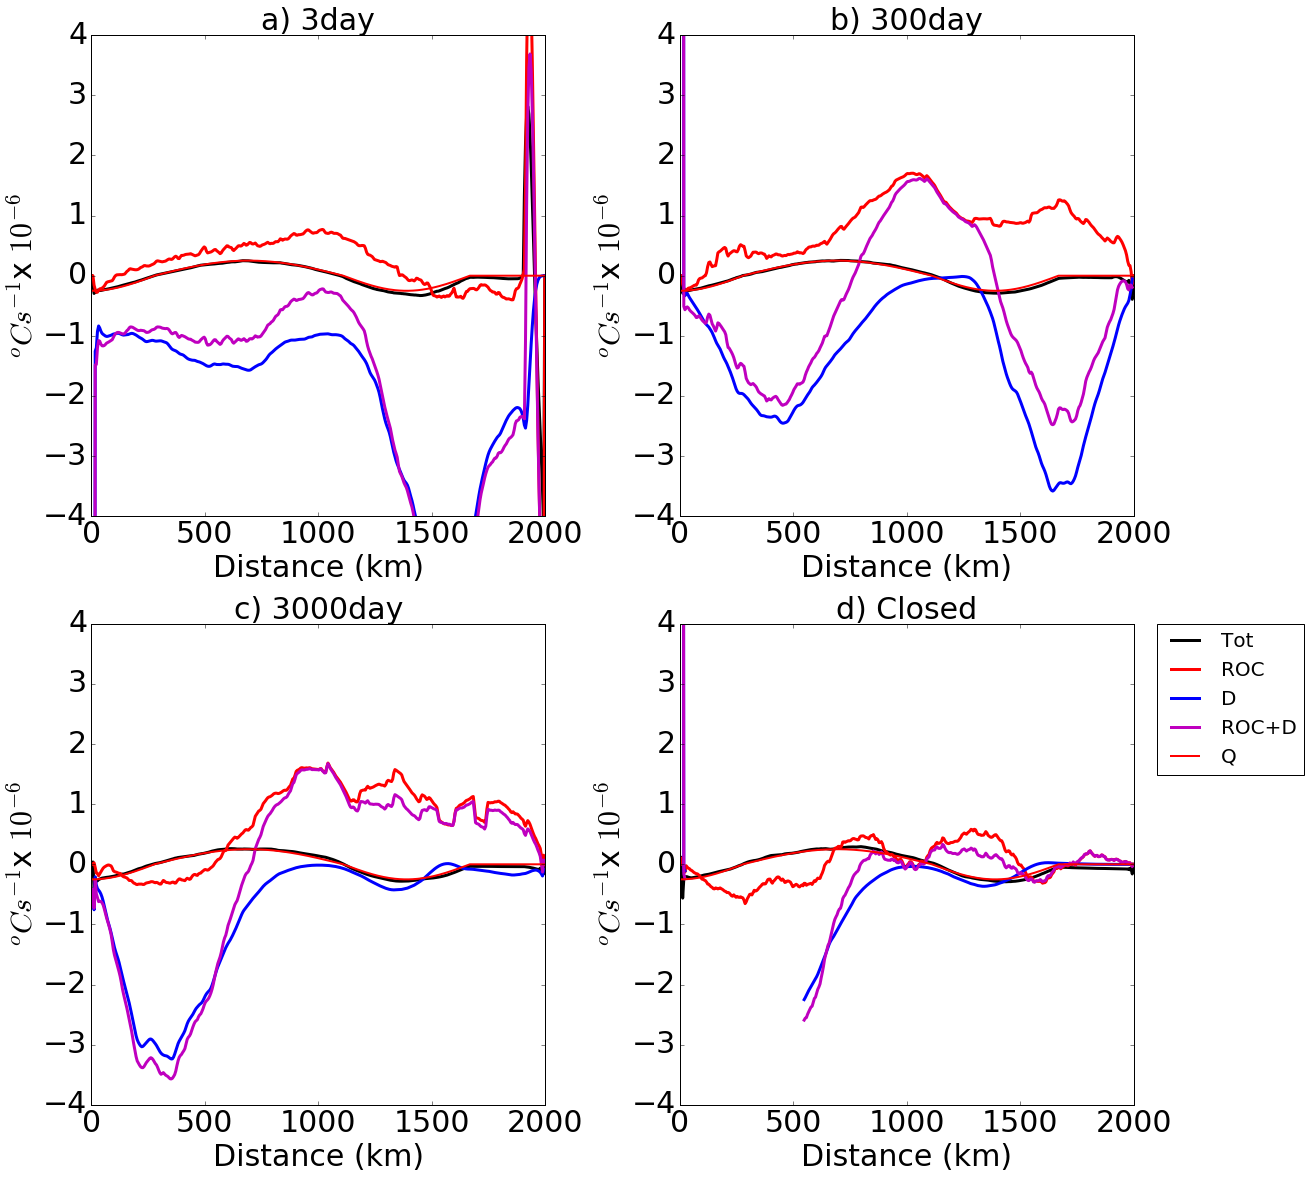

In [25]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((1, 0), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Ade = ((c.vgrid_to_cgrid(VpTp)*Sp)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTp)*Sp)[0:-1,:,:])*CellVol[0:-1,:,:] 
    DE = ((c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[1::,:,:] 
          - (c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[0:-1,:,:])*CellVol[0:-1,:,:] 
    D = -5000*((DE.sum(axis=0))/sum(CellVol)).mean(axis=1)
    
    ROC =-5000*((Ade.sum(axis=0) + dVTe.sum(axis=0) 
                 + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol)).mean(axis=1)
    Adv = ((dVTe.sum(axis=0) + dWTe.sum(axis=0)
           + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol))
    Adv = (dVTe.sum(axis=0) + dWTe.sum(axis=0) + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol)
    Diff = -(5000*Adv).mean(axis=1)
    Q = c.mnc('SURF.nc','oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000*3985)
    #########################
    #     Residual mean     #
    #########################
    th = c.mnc('PSI.nc',"LaHs1TH") # Layer thicknes
    lvrho = c.mnc('PSI.nc',"LaVH1TH") # layer transport
    PI = c.mnc('PSI.nc',"LaPs1TH") # layer probability
    VT = np.mean(lvrho, axis=2)  # Zonal average
    VTfdz = np.cumsum(VT[ ::-1, :], axis=0)  # sum up the water column
    VTfdz = VTfdz
    # Time average and put into Sv and put back in right order
    psi = VTfdz[ ::-1, :]
    psiz = c.get_psi_iso_z()
    Py = (utils.cgrid_to_vgrid(psiz)[:,0:-1] - utils.cgrid_to_vgrid(psiz)[:,1::])*CellVol[:,:,10]/5000**2
    Pz = (utils.cgrid_to_wgrid(psiz)[1::,:] - utils.cgrid_to_wgrid(psiz)[0:-1,:])*CellVol[:,:,10]/5000**2
    npad = ((0, 1), (0, 0), (0, 0))
    Tz = np.pad(Tz, pad_width=npad, mode='constant', constant_values=0)
    npad = ((0, 1), (0, 0))
    Pz = np.pad(Pz, pad_width=npad, mode='constant', constant_values=0)
    ROC = (Py*c.wgrid_to_cgrid(Tz).mean(axis=2) + c.wgrid_to_cgrid(Pz)*Ty.mean(axis=2)).sum(axis=0)/sum(CellVol)

    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000,(Diff+Surcor)*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC),'r',linewidth=3)
    p = plt.plot(c.yc/1000,(D)*10**6,'b',linewidth=3)
    p = plt.plot(c.yc/1000,ROC+(D+Surcor)*10**6,'m',linewidth=3)
    p = plt.plot(c.yc/1000,(Psipred/c.dzf[0])*10**6,'r',linewidth=2)
    plt.ylim(-4,4)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'Tot','ROC','D','ROC+D','Q',
                  'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

# Layer probability for mixed layer

In [35]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    i=0
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = utils.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = utils.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    npad = ((1, 0), (0, 0), (0, 0))
    W = np.pad(W, pad_width=npad, mode='constant', constant_values=0)
    WT = np.pad(WT, pad_width=npad, mode='constant', constant_values=0)
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol#[0:-1,:,:]
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol#[0:-1,:,:]
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol#[0:-1,:,:]
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp = -Ty/Tz
    Ade = ((c.vgrid_to_cgrid(VpTp)*Sp)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTp)*Sp)[0:-1,:,:])*CellVol[0:-1,:,:] 
    DE = ((c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[1::,:,:] 
          - (c.wgrid_to_cgrid(WpTp)-(c.vgrid_to_cgrid(VpTp)*Sp))[0:-1,:,:])*CellVol[0:-1,:,:] 
    D = -5000*((DE.sum(axis=0))/sum(CellVol)).mean(axis=1)
    
    ROC =-5000*((Ade.sum(axis=0) + dVTe.sum(axis=0) 
                 + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol)).mean(axis=1)
    Adv = ((dVTe.sum(axis=0) + dWTe.sum(axis=0)
           + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol))
    Adv = (dVTe.sum(axis=0) + dWTe.sum(axis=0) + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol)
    Diff = -(5000*Adv).mean(axis=1)
    Q = c.mnc('SURF.nc','oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000*3985)
    #########################
    #     Residual mean     #
    #########################
    th = c.mnc('PSI.nc',"LaHs1TH").mean(axis=2)  # Layer thicknes
    lvrho = c.mnc('PSI.nc',"LaVH1TH").mean(axis=2)  # layer transport
    PI = c.mnc('PSI.nc',"LaPs1TH").mean(axis=2) # layer probability
    g = Layers_calc.LayersComputer(utils.ChannelSetup(output_dir=str(x+'/'+str(tau[Runs[i]])+'daynokpp/')))
    PIz = g.transform_g_to_z(PI,th)
    Pmsk = PI < 0.05 # layer exists
    #lvrho =   ma.masked_array(lvrho,SD)
    VT = lvrho # Zonal average
    VTfdz = np.cumsum(VT[ ::-1, :], axis=1)  # sum up the water column
    VTfdz = VTfdz
    # Time average and put into Sv and put back in right order
    psi = VTfdz[ ::-1, :]
    z = cumsum(th, axis=0)
    depth = np.mean(c.Depth,axis=1) # Must use depth for Topo runs!!                                          
    psiz = zeros((c.Nz,c.Ny))
    PIz = zeros((c.Nz,c.Ny))
    Zdia = zeros((c.Ny))
    for jj in arange(c.Ny):
        layer_depth = z[:,jj] - depth[jj]
        psiz[:,jj] = interp(c.zc, layer_depth[:], psi[:,jj])
        PIz[:,jj] = interp(c.zc, layer_depth[:], PI[:,jj])
        Zdia[jj] =interp(0.95, PIz[:,jj], c.zc)
    
    Py = (utils.cgrid_to_vgrid(psiz)[:,0:-1] - utils.cgrid_to_vgrid(psiz)[:,1::])*CellVol[:,:,10]/5000**2
    Pz = (utils.cgrid_to_wgrid(psiz)[1::,:] - utils.cgrid_to_wgrid(psiz)[0:-1,:])*CellVol[:,:,10]/5000**2
    npad = ((0, 1), (0, 0), (0, 0))
    Tz = np.pad(Tz, pad_width=npad, mode='constant', constant_values=0)
    npad = ((0, 1), (0, 0))
    Pz = np.pad(Pz, pad_width=npad, mode='constant', constant_values=0)
    ROC = (Py*Tz.mean(axis=2) + Pz*Ty.mean(axis=2)).sum(axis=0)
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000,(Diff+Surcor)*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC),'r',linewidth=3)
    p = plt.plot(c.yc/1000,(D)*10**6,'b',linewidth=3)
    p = plt.plot(c.yc/1000,ROC+(D+Surcor)*10**6,'m',linewidth=3)
    p = plt.plot(c.yc/1000,(Psipred/c.dzf[0])*10**6,'r',linewidth=2)
    plt.ylim(-4,4)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'Tot','ROC','D','ROC+D','Q',
                  'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:35: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:35: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:36: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:37: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:38: RuntimeWarning: invalid value encountered in multiply


/noc/msm/scratch/students/hb1g13/Mobilis/3daynokpp/


/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:39: RuntimeWarning: invalid value encountered in multiply


ValueError: operands could not be broadcast together with shapes (30,400) (31,400) 

In [37]:
g = Layers_calc.LayersComputer(utils.ChannelSetup(output_dir=str(x+'/'+str(tau[Runs[i]])+'daynokpp/')))
PIz = g.transform_g_to_z(PI,th)

/noc/msm/scratch/students/hb1g13/Mobilis/3daynokpp/


In [43]:

Zdia = np.interp(0.95, PIz.mean(axis=1), c.zc)

In [44]:

for kk in range(len(psi[:,1])):
    if np.mean(psi[kk,10:-50])>0:
        if psi[kk,320]<0.9*np.max(psi[kk,10:-50]):
            continue
        psi[kk,:]=np.max(psi[kk,10:-50])
    else:
        if psi[kk,300]>0.5*np.min(psi[kk,10:-50]):
            continue
        psi[kk,:]=np.min(psi[kk,10:-50])

-5.0

/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:31: RuntimeWarning: divide by zero encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:31: RuntimeWarning: invalid value encountered in divide
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:32: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:33: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:34: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:35: RuntimeWarning: invalid value encountered in multiply
/noc/users/hb1g13/anaconda/lib/python2.7/site-packages/IPython/kernel/__main__.py:33: RuntimeWarning: invalid value encountered in subtract
/noc/users/hb1g13/anaco

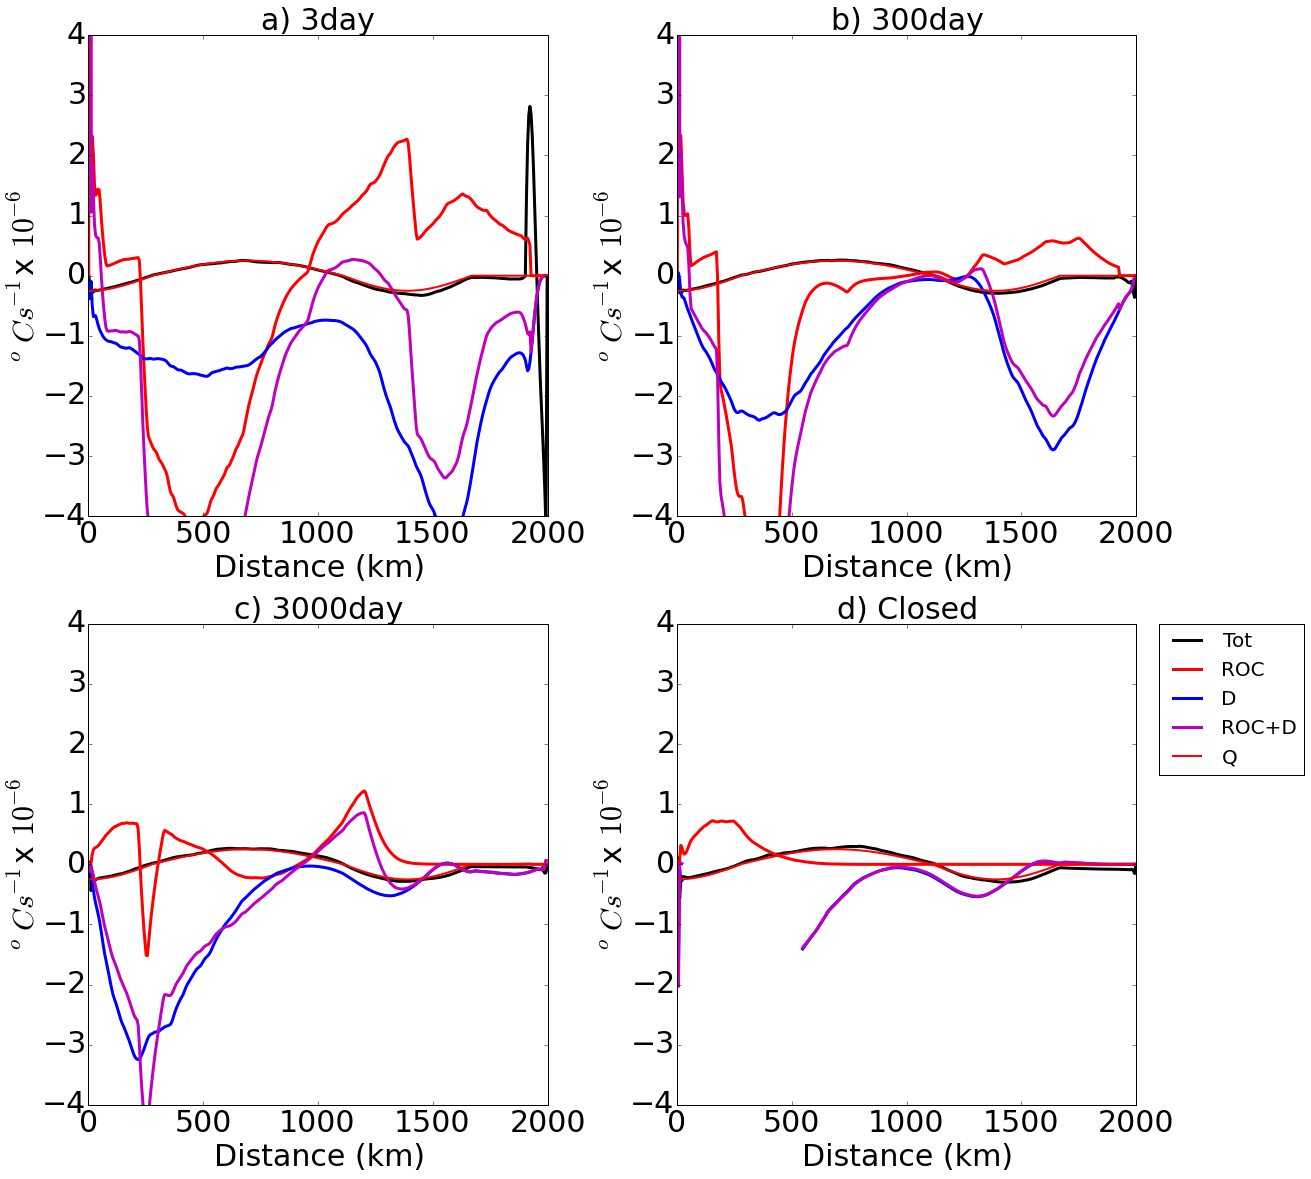

In [45]:
fig = plt.figure(figsize=(16.5, 16.5))
for i in range(len(Runs)):
    fname = x+'/'+str(tau[Runs[i]])+'daynokpp/'
    c = utils.ChannelSetup(output_dir=str(fname))
    # PLOT PANNELS
    CellVol = c.rac*tile(c.dzf,(c.Nx,c.Ny,1)).T
    Nx,Ny,Nz = c.Nx, c.Ny, c.Nz
    # load V, W, T bar    
    # put everything on the C Grid                        
    VT = (c.mnc('Tav_VT.nc','VVELTH'))
    WT = (c.mnc('Tav_VT.nc','WVELTH'))
    Tv = c.cgrid_to_vgrid(c.mnc('Tav.nc','THETA'))
    Tw = c.cgrid_to_wgrid(c.mnc('Tav.nc','THETA'))
    V = (c.mnc('Tav.nc','VVEL'))
    W = (c.mnc('Tav.nc','WVEL'))
    VTbar = V*Tv
    WTbar = W*Tw
    VpTp = VT - VTbar
    WpTp = WT - WTbar
    # Vertical Mass-Weight Transp of Pot Temp (K.m/s)
    WTHMASS = c.mnc('SURF.nc', 'WTHMASS')
    # Surface cor
    Surcor = (WTHMASS.mean(axis=0)).mean(axis=1)
    dVTbar = (VTbar[:,0:-1,:] - VTbar[:,1::,:])*CellVol
    dWTbar = (WTbar[1::,:,:] - WTbar[0:-1,:,:])*CellVol[0:-1,:,:]
    dVTe = (VpTp[:,0:-1,:] - VpTp[:,1::,:])*CellVol
    dWTe = (WpTp[1::,:,:] - WpTp[0:-1,:,:])*CellVol[0:-1,:,:]
    Ty = (Tv[:,0:-1,:] - Tv[:,1::,:])*CellVol
    Tz = (Tw[1::,:,:] - Tw[0:-1,:,:])*CellVol[0:-1,:,:]
    Sp = zeros((c.Nz,c.Ny,c.Nx))
    Sp[0:-1,:,:] = -Ty[0:-1,:,:]/Tz
    Ade = ((c.vgrid_to_cgrid(VpTp)*Sp)[1::,:,:] 
           - (c.vgrid_to_cgrid(VpTp)*Sp)[0:-1,:,:])*CellVol[0:-1,:,:] 
    DE = ((WpTp-(c.vgrid_to_cgrid(VpTp)*Sp))[1::,:,:] 
          - (WpTp-(c.vgrid_to_cgrid(VpTp)*Sp))[0:-1,:,:])*CellVol[0:-1,:,:] 
    D = -5000*((DE.sum(axis=0))/sum(CellVol)).mean(axis=1)
    ROC =-5000*((Ade.sum(axis=0) + dVTe.sum(axis=0) 
                 + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol)).mean(axis=1)
    Adv = ((dVTe.sum(axis=0) + dWTe.sum(axis=0)
           + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol))
    Adv = (dVTe.sum(axis=0) + dWTe.sum(axis=0) + dVTbar.sum(axis=0) + dWTbar.sum(axis=0))/sum(CellVol)
    Diff = -(5000*Adv).mean(axis=1)
    Q = c.mnc('SURF.nc','oceQnet').mean(axis=0).mean(axis=1)
    Psipred = (Q)/(1000*3985)
    
    
    #########################
    #     Residual mean     #
    #########################
    # --> Surface ROC
    psi = c.get_psi_iso()
    for kk in range(len(psi[:,1])):
        if np.mean(psi[kk,10:-50])>0:
            if psi[kk,320]<0.9*np.max(psi[kk,10:-50]):
                continue
            psi[kk,:]=np.max(psi[kk,10:-50])
        else:
            if psi[kk,300]>0.5*np.min(psi[kk,10:-50]):
                continue
            psi[kk,:]=np.min(psi[kk,10:-50])
    
    psiz = get_psi_iso_z(psi, c.mnc('PSI.nc',"LaHs1TH").mean(axis=2),c.zc)/10**6
    ROC = c.vgrid_to_cgrid(psiz)[0,:]*np.nanmean(Ty[0,:,:],axis=1)
    ROC[-15::] = 0
    ROC[0] = 0
    ax = fig.add_subplot(2, 2, i+1)
    p = plt.plot(c.yc/1000,(Diff+Surcor)*10**6,'k',linewidth=3)
    p = plt.plot(c.yc/1000,(ROC/10**6),'r',linewidth=3)
    p = plt.plot(c.yc/1000,(D)*10**6,'b',linewidth=3)
    p = plt.plot(c.yc/1000,ROC/10**6+(D+Surcor)*10**6,'m',linewidth=3)
    p = plt.plot(c.yc/1000,(Psipred/c.dzf[0])*10**6,'r',linewidth=2)
    plt.ylim(-4,4)
    ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]])+'day', fontsize=30)
    if str(tau[Runs[i]]) == 'Closed':
        ax.set_title(str(Figletter[Runs[i]])+str(tau[Runs[i]]), fontsize=30)
    ax.set_xlabel('Distance (km)', fontsize=30)
    ax.set_ylabel(r'$^oCs^{-1}$x $10^{-6}$', fontsize=30)
    ax.tick_params(axis='both', which='major', labelsize=30)
lgd = plt.legend([r'Tot','ROC','D','ROC+D','Q',
                  'Q'],bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.,fontsize=20)
plt.tight_layout()

#Residual mean mixed layer depth

\begin{equation}
   \Psi_{res}  |_{hml}   =  \left( Q + \int_{-hml}^{0}\frac{\partial \left(w'T' - \overline{v'T'}.Sp  \right)}{\partial z} \mathrm{d}z \right) \left(  \frac{\partial \overline{b} }{\partial y }  \right)^{-1} 
\end{equation}